In [20]:
#Verifico la capacidad de GPU
!nvidia-smi

Mon Nov 18 03:49:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:41:00.0 Off |                  N/A |
| 58%   83C    P2            120W /  320W |    9969MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
#Librerias a importar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

In [22]:
# Transformación para entrenamiento
train_transform = transforms.Compose([
    transforms.Resize(256),  # Cambia el tamaño para hacer el recorte centrado
    transforms.CenterCrop(224),  # Asegura el recorte centrado
    transforms.RandomHorizontalFlip(),  # Flip horizontal para aumentar los datos
    transforms.RandomVerticalFlip(),  # Flip vertical para aumentar los datos
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformaciones para validación
val_transform = transforms.Compose([
    transforms.Resize(256),  # Asegura el redimensionado
    transforms.CenterCrop(224),  # Recorta centrado
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformaciones para prueba
test_transform = transforms.Compose([
    transforms.Resize(256),  # Asegura el redimensionado
    transforms.CenterCrop(224),  # Recorta centrado
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Cargar los datos con las nuevas transformaciones
train_dataset = torchvision.datasets.ImageFolder(root='../../dataset/ganado/train', transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root='../../dataset/ganado/validation', transform=val_transform)
test_dataset = torchvision.datasets.ImageFolder(root='../../dataset/ganado/test', transform=test_transform)

print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ../../dataset/ganado/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 300
    Root location: ../../dataset/ganado/validation
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 300
    Root location: ../../dataset/ganado/test
    StandardTransform
Transform: Compose(

In [23]:
# Imprimo un resumen de los datos
print('Train:', len(train_dataset))

Train: 3000


In [24]:
import os
from torch.utils.data.sampler import SubsetRandomSampler # type: ignore

batch_size = 4
learning_rate = 0.001
num_epocas = 50
step_log = 100
num_workers = os.cpu_count()

# Porcentaje de datos de validación
valid_size = 0.20  # 20% para validación

# Obtener los índices para el dataset de entrenamiento y dividir para validación
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Definir los samplers para entrenamiento y validación
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Definir DataLoaders para entrenamiento, validación y test
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

class_names = train_dataset.classes

print(f"Usando {num_workers} workers para cargar datos.")

Usando 64 workers para cargar datos.


In [25]:
# Imprimo el nombre de las clases
class_names = train_dataset.classes
print(train_dataset.classes)

['alpacas', 'llamas', 'ovejas']


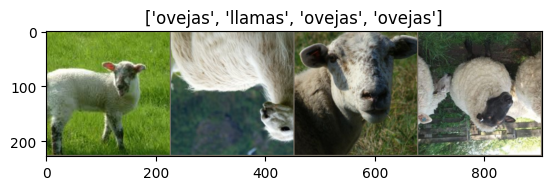

In [26]:
# Cargo un batch de imagenes
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  
dataiter = iter(train_loader)
inputs, classes = next(dataiter)

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

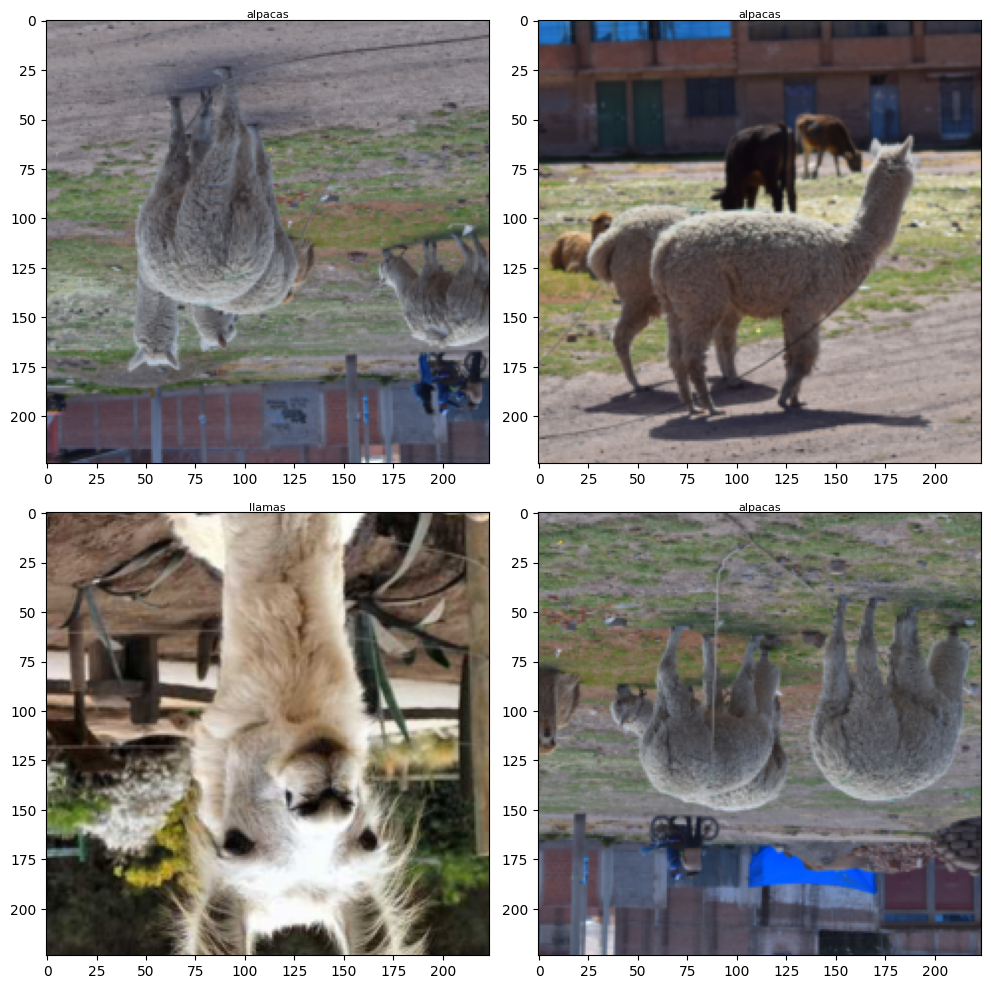

In [27]:
# Se grafican nuevamente, pero con los nombres de las clases truncados
def imshow_with_class_name(inp, class_name, ax=None):   
    
    if ax is None:
        ax = plt.gca()

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)

      # Limit class name to 15 characters using slicing
    max_length = 15
    title = class_name[:max_length]  # Truncate at the specified index
    if len(class_name) > max_length:
        title += "..."  # Add ellipsis to indicate truncation

    ax.set_title(title, fontsize=8, ha='center', va='top')

dataiter = iter(train_loader)
inputs, classes = next(dataiter)

# Crear una cuadrícula de 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Mostrar las imágenes y los nombres de las clases en cada subplot
for i, (inp, class_name) in enumerate(zip(inputs, classes)):
    row = i // 2
    col = i % 2
    imshow_with_class_name(inp, class_names[class_name], axes[row, col])

# Eliminar bordes y espacios entre subplots
plt.tight_layout()
plt.show()

In [28]:
torch.cuda.set_device(1) 
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print("Se entrenara con:", device)

Se entrenara con: cuda


In [29]:
# Imprimo el numero de clases
num_classes = len(class_names)
print(num_classes)

3


In [30]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 256, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
        
        self.fc1 = nn.Linear(512*26*26, 50)  # 50 neuronas en la capa densa
        self.fc2 = nn.Linear(50, 3)  # 2 salidas: una para la media y otra para la log-varianza

    def forward(self, x):
        # Aplicación de convoluciones + ReLU + Pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.bn1(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x, dim=-1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # todas las dimensiones excepto la del batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Instanciar el modelo
network = Network()

In [31]:
model = network.to(device)

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [42]:
import os
import json

# Definir funciones para cargar y guardar métricas
def load_metrics(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as f:
            return json.load(f)
    return {"train_losses": [], "valid_losses": [], "accuracy_train_list": [], "accuracy_valid_list": []}

def save_metrics(file_path, metrics):
    with open(file_path, 'w') as f:
        json.dump(metrics, f)

# Ruta del archivo donde se guardarán las métricas
metrics_file = 'metrics_01.json'
metrics = load_metrics(metrics_file)

# Cargar las métricas anteriores
train_losses = metrics["train_losses"]
valid_losses = metrics["valid_losses"]
accuracy_train_list = metrics["accuracy_train_list"]
accuracy_valid_list = metrics["accuracy_valid_list"]

# Definir parámetros
valid_loss_min = min(valid_losses) if valid_losses else float('inf')  # Valor mínimo de valid_loss si existe

# Bucle de entrenamiento por épocas
for epoch in range(1, num_epocas + 1):
    # Inicializar las pérdidas de entrenamiento y validación
    train_loss = 0.0
    valid_loss = 0.0
    correct_train = 0  # Para contar las predicciones correctas en el entrenamiento
    total_train = 0  # Para contar el total de muestras de entrenamiento
    correct_valid = 0  # Para contar las predicciones correctas en la validación
    total_valid = 0  # Para contar el total de muestras de validación

    # ---- Entrenamiento ----
    model.train()  # Poner el modelo en modo de entrenamiento
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Limpiar los gradientes
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calcular la pérdida de entrenamiento
        loss.backward()  # Backward pass
        optimizer.step()  # Optimización

        train_loss += loss.item() * data.size(0)  # Actualizar pérdida
        _, pred = torch.max(output, dim=1)  # Predicciones
        correct_train += (pred == target).sum().item()  # Sumar correctas
        total_train += target.size(0)  # Total muestras

    # ---- Validación ----
    model.eval()  # Modo evaluación
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)  # Calcular la pérdida de validación
            valid_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            correct_valid += (pred == target).sum().item()
            total_valid += target.size(0)

    # Calcular las pérdidas promediadas
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    # Calcular la precisión promedio en entrenamiento y validación
    train_accuracy = 100 * correct_train / total_train
    valid_accuracy = 100 * correct_valid / total_valid

    # Guardar las pérdidas y las precisiones
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    accuracy_train_list.append(train_accuracy)
    accuracy_valid_list.append(valid_accuracy)

    # Imprimir resultados por época
    print(f'Epoch: {epoch}/{num_epocas}')
    print(f'Training Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
    print(f'Training Accuracy: {train_accuracy:.2f}% \tValidation Accuracy: {valid_accuracy:.2f}%')

    # Guardar el modelo si la pérdida de validación ha disminuido
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'ganado_propio_cross.pt')  # Guardar modelo
        valid_loss_min = valid_loss  # Actualizar mejor pérdida

    # Guardar métricas actualizadas
    save_metrics(metrics_file, {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "accuracy_train_list": accuracy_train_list,
        "accuracy_valid_list": accuracy_valid_list
    })

# Finalización del entrenamiento
print("Entrenamiento completo")

Epoch: 1/50
Training Loss: 0.637116 	Validation Loss: 0.882118
Training Accuracy: 92.58% 	Validation Accuracy: 64.67%
Epoch: 2/50
Training Loss: 0.636065 	Validation Loss: 0.862853
Training Accuracy: 92.79% 	Validation Accuracy: 68.00%
Epoch: 3/50
Training Loss: 0.631589 	Validation Loss: 0.856037
Training Accuracy: 93.25% 	Validation Accuracy: 68.33%
Epoch: 4/50
Training Loss: 0.626389 	Validation Loss: 0.868314
Training Accuracy: 93.83% 	Validation Accuracy: 67.17%
Epoch: 5/50
Training Loss: 0.628969 	Validation Loss: 0.858484
Training Accuracy: 93.50% 	Validation Accuracy: 68.00%
Epoch: 6/50
Training Loss: 0.618093 	Validation Loss: 0.853685
Training Accuracy: 94.75% 	Validation Accuracy: 68.50%
Epoch: 7/50
Training Loss: 0.622089 	Validation Loss: 0.872965
Training Accuracy: 94.38% 	Validation Accuracy: 66.83%
Epoch: 8/50
Training Loss: 0.613592 	Validation Loss: 0.853766
Training Accuracy: 95.17% 	Validation Accuracy: 68.67%
Epoch: 9/50
Training Loss: 0.611126 	Validation Loss: 0.

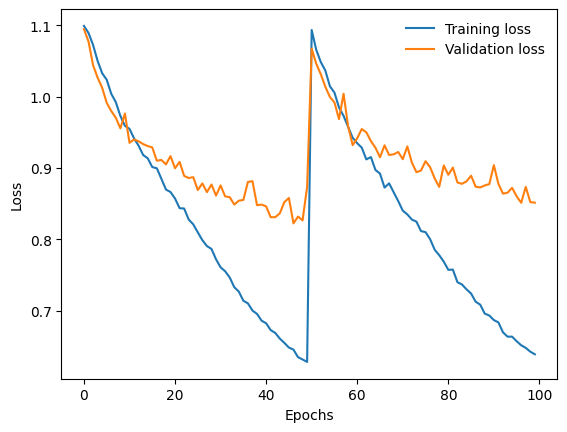

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [39]:
# Test
model.eval()  # se deshabilitan las capas de dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        # print([img.size() for img in images])  # Esto imprimirá los tamaños de las imágenes en cada lote
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'ganado_propio_cross.ckpt')

Test Accuracy of the model: 87.33333333333333 %


In [40]:
# Funcion para visualizar las predicciones de test
def visualize_model(model, num_images):
    was_training = model.training
    
    model.eval()
    images_so_far = 0       
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
                    
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images, 1, images_so_far)
                
                ax.axis('off')
                ax.set_title('Predicted: {} (Clase: {})'.format(class_names[preds[j]], class_names[labels[j]]))
                                
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return           
                
        model.train(mode = was_training)

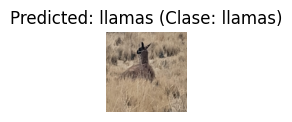

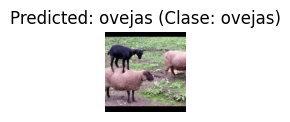

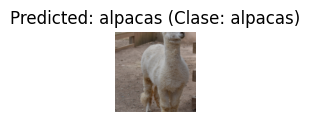

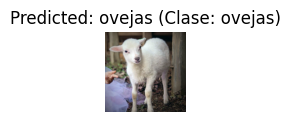

In [41]:
visualize_model(model=model, num_images = 4)